In [1]:
import pandas as pd
import time
import datetime
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit

In [2]:
#df = pd.read_csv("training_set_VU_DM.csv")
df = pd.read_csv("sample_training_set.csv")

# Get a sample from the training dataset
# df = df.sample(n=500000)
# df.to_csv('sample_training_set.csv')

## Notes
- There are multiple search results for the same search id
- No. unique id's in the full training set is 199795, 175188 in the sample set
- Position, click_bool , booking_bool and gross_booking_usd is not included in test set! 

In [3]:
# Make a descriptive dataframe
df_descr = pd.concat([df.nunique(), df.isna().sum(), df.dtypes, df.max(), df.min()], axis=1)
df_descr.columns = ['Unique values', 'NaN count', 'Datatype', 'Max value', 'Min value']
df_descr

,Unique values,NaN count,Datatype,Max value,Min value
Unnamed: 0,500000,0,int64,4958341,44
srch_id,175188,0,int64,332785,4
date_time,174292,0,object,2013-06-30 23:58:24,2012-11-01 00:08:29
site_id,34,0,int64,34,1
visitor_location_country_id,209,0,int64,231,1
visitor_hist_starrating,307,474303,float64,5.0,1.5
visitor_hist_adr_usd,6995,474185,float64,1958.7,0.0
prop_country_id,167,0,int64,230,1
prop_id,83144,0,int64,140821,1
prop_starrating,6,0,int64,5,0


array([[<AxesSubplot:title={'center':'prop_starrating'}>,
        <AxesSubplot:title={'center':'prop_review_score'}>,
        <AxesSubplot:title={'center':'prop_brand_bool'}>,
        <AxesSubplot:title={'center':'promotion_flag'}>,
        <AxesSubplot:title={'center':'srch_adults_count'}>],
       [<AxesSubplot:title={'center':'srch_children_count'}>,
        <AxesSubplot:title={'center':'srch_room_count'}>,
        <AxesSubplot:title={'center':'srch_saturday_night_bool'}>,
        <AxesSubplot:title={'center':'random_bool'}>,
        <AxesSubplot:title={'center':'comp1_rate'}>],
       [<AxesSubplot:title={'center':'comp1_inv'}>,
        <AxesSubplot:title={'center':'comp2_rate'}>,
        <AxesSubplot:title={'center':'comp2_inv'}>,
        <AxesSubplot:title={'center':'comp3_rate'}>,
        <AxesSubplot:title={'center':'comp3_inv'}>],
       [<AxesSubplot:title={'center':'comp4_rate'}>,
        <AxesSubplot:title={'center':'comp4_inv'}>,
        <AxesSubplot:title={'center':'comp5

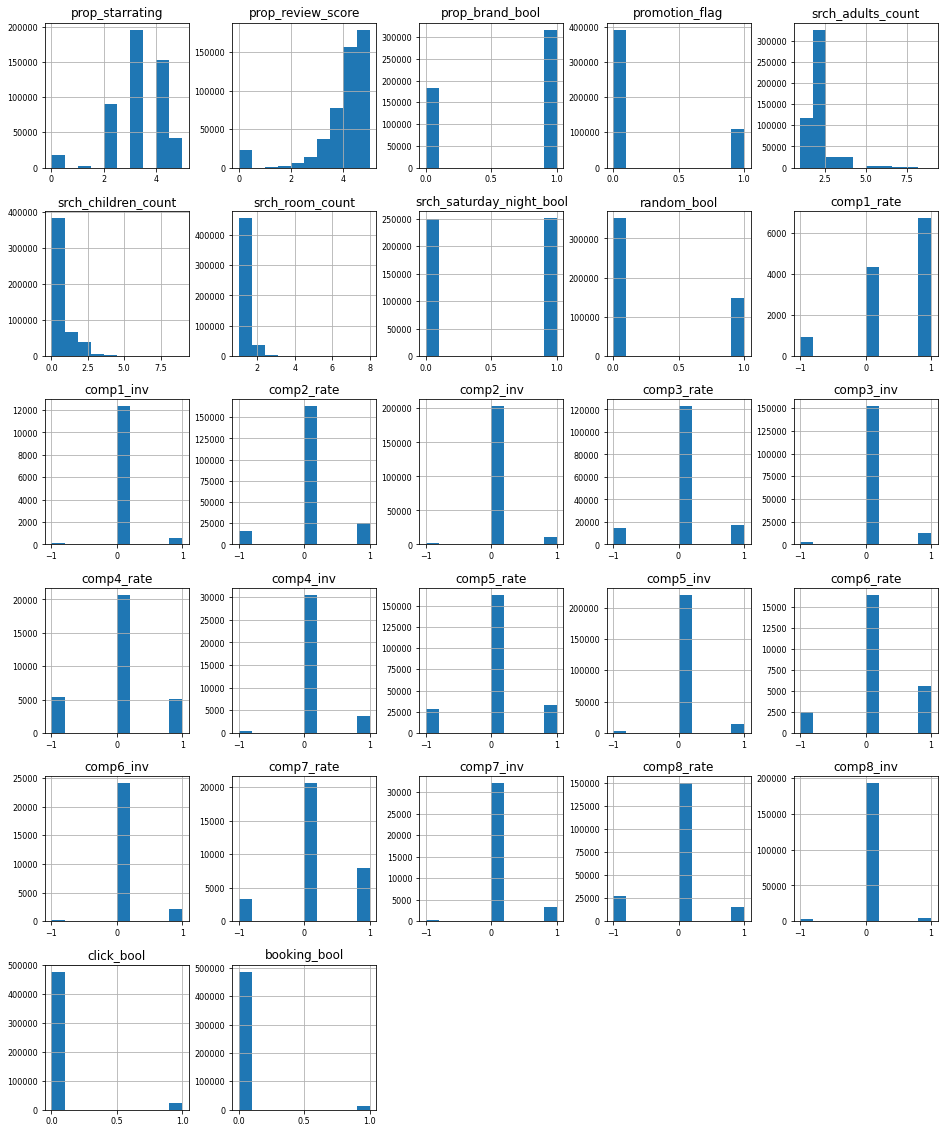

In [5]:
descr2 = df_descr[df_descr['Unique values'] <= 10].index.tolist() # (almost) all are categorical variables
#descr3 = df_descr[df_descr['Unique values'] > 50].index.tolist() # (almost) all are numerical variables


df[descr2].hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)
# descr3.remove('date_time')
# print(descr3)
#df.boxplot(column=descr3, figsize=(16, 20))



# To do - ?
- Count the amount of clicks per property and plot
- Fill in missing values (are a lot)
- Identify multiple searches of 1 user on 1 property?
- Explore if further data transformation is necessary - how to deal with sparse data
- For modelling: group by user and make ranking

In [6]:
# Show top 5 occuring properties
df2 = df.groupby('prop_id').count()
df2 = df2.sort_values(['srch_id'],ascending=False).head()
print(df2['srch_id'])

# Show top 5 booked properties
df_top5_prop = df.groupby('prop_id').agg({'booking_bool': sum})
df_top5_prop = df_top5_prop.sort_values(['booking_bool'],ascending=False).head()
df_top5_prop

prop_id
59781     264
124342    252
77795     251
104517    250
21018     240
Name: srch_id, dtype: int64


,booking_bool
prop_id,
53494,15
77089,14
22578,14
53547,13
116942,12


<ipython-input-7-d03cd1cd9389>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['booking_bool'] = df['booking_bool'].values


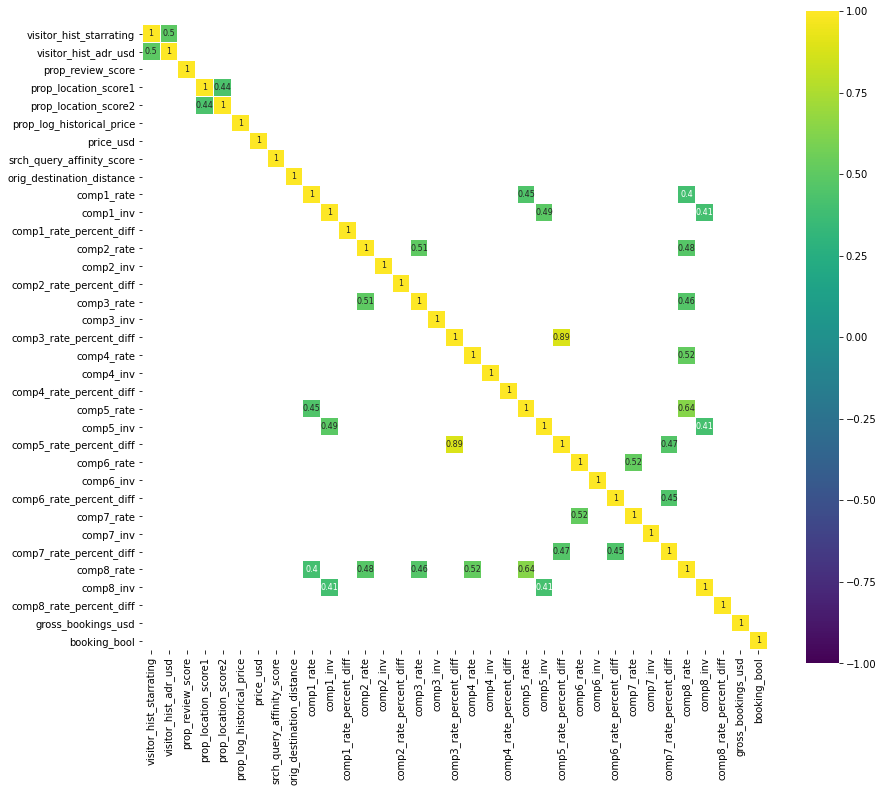

In [7]:
# Plot correlation matrix of all float values + booking or not
df_num = df.select_dtypes(include=[float])
df_num['booking_bool'] = df['booking_bool'].values
corr = df_num.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);


In [8]:
#df = pd.read_csv("test_set_VU_DM.csv")
#df

## Already try some model, doesnt work (yet)
#### See https://medium.com/predictly-on-tech/learning-to-rank-using-xgboost-83de0166229d

In [23]:
# Drop date time to not get an error for xgboost
#df.drop('date_time', inplace=True, axis=1)


gss = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(df, groups=df['srch_id'])

X_train_inds, X_test_inds = next(gss)

train_data= df.iloc[X_train_inds]
test_data= df.iloc[X_test_inds]



groups = train_data.groupby('srch_id').size().to_frame('size')['size'].to_numpy()


X_train = train_data.loc[:, ~train_data.columns.isin(['prop_id','booking_bool'])]
y_train = train_data.loc[:, train_data.columns.isin(['booking_bool'])]

X_test = test_data.loc[:, ~test_data.columns.isin(['booking_bool'])]
y_test = test_data.loc[:, test_data.columns.isin(['booking_bool'])]

print(X_test.shape, y_test.shape)


model = xgb.XGBRanker(
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )

model.fit(X_train, y_train, group=groups, verbose=True)

def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(['prop_id'])])

print('model fitted')
  
predictions = (X_test.groupby('srch_id')
               .apply(lambda x: predict(model, x)))

print('predictions done')
predictions



(199981, 53) (199981, 1)


KeyboardInterrupt: 